# Anomaly Detection and Recommender Systems

#### AI Saturday Lagos Begineers Class (Instructors: `Tejumade Afonja`, `Kenechi Dukor`)
This exercise is adopted from [Andrew Ng Machine Learning Course](https://www.coursera.org/learn/machine-learning)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
import scipy as sp
import re

### Anomaly Detection

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server.

In [ ]:
data = loadmat('data/ex8data1.mat')
data.keys()

In [ ]:
X = data['X']
X_val = data['Xval']
y_val = data['yval']

In [ ]:
print(f'Shape of Training Data: {X.shape}')
print(f'Shape of Validation: {X_val.shape}')

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(X[:,0], X[:,1], marker='+')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)');

### Estimate parameters for the gaussian

To perform anomaly detection, you will first need to fit a model to the data’s distribution. Given a training set {x(1), …, x(m)} (where x(i) ∈ R^n, here n = 2), you want to estimate the Gaussian distribution for each of the features. For each feature (i = 1 . . . n), you need to find parameters mean and variance(mu, sigma²). 

In [ ]:
mu = np.mean(X, axis=0) # Mean
std = np.std(X, axis=0) # Standard Deviation

In [ ]:
print(f'the mean is: {list(mu)}')
print(f'the std is: {list(std)}')

In [ ]:
def gaussian_2d(X, mu, std):
    k = mu.size

    sigma2 = std**2
    Sigma2 = np.diag(sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5)\
    * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(Sigma2)) * X, axis=1))
    
    return p

def visualizeGaussian(X, mu, std, X_val=None):
    
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = gaussian_2d(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, std)
    Z = Z.reshape(X1.shape)
    
    plt.figure(figsize=(10,5))

    plt.scatter(X[:, 0], X[:, 1], marker='+')
    
    
    if np.all(abs(Z) != np.inf):
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), zorder=100)

In [ ]:
visualizeGaussian(X,mu,std,X_val)

### Selecting the threshold, ε

In [ ]:
def selectThresh(y,p):
    beste = 0
    bestF1 = 0
    F1 = 0
    y = y.ravel()
    es = []
    bfs = []
    
   # we find the stepsize to have a wide range of threshold values to decide the best one.
    for e in np.linspace(1.01*min(p), max(p), 1000): 
        # ====================== YOUR CODE HERE =======================
        res = (p < e)*1
        tp = np.sum((res == 1) * (y == 1))
        fp = np.sum((res == 1) * (y == 0))
        fn = np.sum((res == 0) * (y == 1))
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        F1 = (2*precision*recall)/(precision+recall)
        es.append(e)
        bfs.append(F1)
        # =============================================================
        
        if F1 > bestF1:
            print(f'-- F1:{F1}, bestF1:{bestF1}, beste:{e}')
            bestF1 = F1
            beste = e
    history = [es, bfs]
    return beste, bestF1, history

In [ ]:
y_val.shape

In [ ]:
p = gaussian_2d(X_val,mu,std)
epsilon, bF1, history = selectThresh(y_val,p)

In [ ]:
plt.plot(history[0], history[1])
plt.xlabel('epsilon')
plt.ylabel('F1 score')

In [ ]:
pred_anom = ((p < epsilon)*1 == y_val.ravel())*1
pred_anom

In [ ]:
pred = (p < epsilon)*1

In [ ]:
pred

validation anomalies

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X_val[pred == 0][:,0],X_val[pred == 0][:,1])
plt.scatter(X_val[pred == 1][:,0],X_val[pred == 1][:,1], c='red')

# Recommender System

We will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings (MovieLens 100k Dataset from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies.

### Load Data

#### Movies rating dataset

We will load the dataset `ex8_movies.mat`, providing the variables `Y` and `R`. The matrix `Y` (a num_movies $\times$ num_users matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix `R` is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

In [2]:
data2 = loadmat('data/ex8_movies.mat')

In [3]:
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [4]:
Y = data2['Y']
R = data2['R']

In [5]:
print("Y shape: ", Y.shape, "and R shape: ", R.shape)

Y shape:  (1682, 943) and R shape:  (1682, 943)


Lets take a look at the actual movies that exist in the dataset and preprocess them into a `word_index`

In [6]:
data_movie_ids = np.loadtxt('data/movie_ids.txt', dtype=np.str, delimiter='\n')

In [7]:
data_movie_ids

array(['1 Toy Story (1995)', '2 GoldenEye (1995)', '3 Four Rooms (1995)',
       ..., '1680 Sliding Doors (1998)', '1681 You So Crazy (1994)',
       '1682 Scream of Stone (Schrei aus Stein) (1991)'], dtype='<U86')

In [8]:
# Restructuring to word_index
index_movie_list = [re.split(' ', row, maxsplit=1) for row in data_movie_ids]
movie_index_dict = {movie: int(index) - 1 for index, movie in index_movie_list}

In [9]:
movie_index_dict

{'Toy Story (1995)': 0,
 'GoldenEye (1995)': 1,
 'Four Rooms (1995)': 2,
 'Get Shorty (1995)': 3,
 'Copycat (1995)': 4,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 5,
 'Twelve Monkeys (1995)': 6,
 'Babe (1995)': 7,
 'Dead Man Walking (1995)': 8,
 'Richard III (1995)': 9,
 'Seven (Se7en) (1995)': 10,
 'Usual Suspects, The (1995)': 11,
 'Mighty Aphrodite (1995)': 12,
 'Postino, Il (1994)': 13,
 "Mr. Holland's Opus (1995)": 14,
 'French Twist (Gazon maudit) (1995)': 15,
 'From Dusk Till Dawn (1996)': 16,
 'White Balloon, The (1995)': 17,
 "Antonia's Line (1995)": 18,
 'Angels and Insects (1995)': 19,
 'Muppet Treasure Island (1996)': 20,
 'Braveheart (1995)': 21,
 'Taxi Driver (1976)': 22,
 'Rumble in the Bronx (1995)': 23,
 'Birdcage, The (1996)': 24,
 'Brothers McMullen, The (1995)': 25,
 'Bad Boys (1995)': 26,
 'Apollo 13 (1995)': 27,
 'Batman Forever (1995)': 28,
 'Belle de jour (1967)': 29,
 'Crimson Tide (1995)': 30,
 'Crumb (1994)': 31,
 'Desperado (1995)': 32,
 'Doom 

#### Simple Exploration

In [10]:
index = movie_index_dict['Toy Story (1995)']
print (np.mean(Y[index][R[index] == 1]))

3.8783185840707963


In [11]:
# find the mean of movies that were no rated

#### Visualization

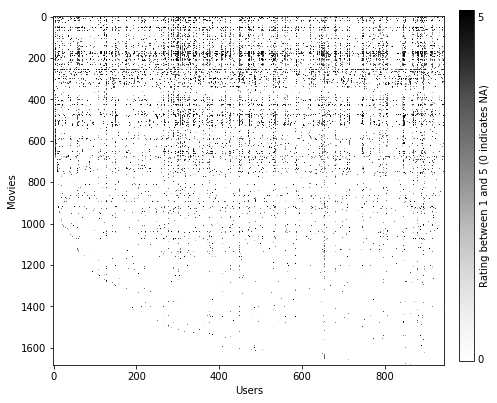

In [12]:
fig = plt.figure(figsize=(7,7))
imshow_out = plt.imshow(Y, cmap=plt.get_cmap('Greys'), vmin=0, vmax=5, interpolation = 'nearest', aspect=0.5)
plt.xlabel('Users')
plt.ylabel('Movies')

ax_cb = fig.add_axes([0.93, 0.165, 0.03, 0.695])
markersize = plt.rcParams['lines.markersize'] # The adjustments to 'lines.markersize' in this code block prevent points of size "markersize" from appearing in the corners of the colorbar.
plt.rcParams['lines.markersize'] = 0.1 
fig.colorbar(imshow_out, cax=ax_cb, ticks=[])
ax_cb.text(6, 0.010, '0', verticalalignment='center', horizontalalignment='left')
ax_cb.text(6, 4.9, '5', verticalalignment='center', horizontalalignment='left')
ax_cb.text(7, 2.5, 'Rating between 1 and 5 (0 indicates NA)', verticalalignment='center', horizontalalignment='left', rotation=90)
plt.rcParams['lines.markersize'] = markersize


### Collaborative filtering learning algorithm

#### Load pre-trained weights (X, Theta, num_users, num_movies, num_features)

In [13]:
movies_params_dict = loadmat('data/ex8_movieParams.mat')

In [14]:
movies_params_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [15]:
X = movies_params_dict['X']
Theta = movies_params_dict['Theta']

#### Collaborative Filtering Cost Function

The collaborative filtering cost function (without regularization) is given by

$$
J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

In [16]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    cost = 1 / 2 * np.sum((R * X.dot(Theta.T) - Y)**2)
    return cost

In [17]:
# Cost function and gradients will be tested on a subset of the data.
num_features = 3
num_users = 4
num_movies = 5

X_ = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y_ = Y[:num_movies, :num_users]
R_ = R[:num_movies, :num_users]

params = np.hstack((X_.ravel(), Theta.ravel()))

In [18]:
print ("Cost at loaded parameters:", cofi_cost_func(params, Y_, R_, num_users, num_movies, num_features))

Cost at loaded parameters: 22.224603725685675


#### Regularized Collaborative filtering cost function

The cost function for collaborative filtering with regularization is given by

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

In [19]:
# Implement the regularized version of the collaborative filtering cost function
def cofi_cost_func_reg(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    cost = 1 / 2 * np.sum((R * X.dot(Theta.T) - Y)**2) + lam / 2 * np.sum(X**2) + lam / 2 * np.sum(Theta**2)
    return cost

In [20]:
lam = 1.5
print ("Cost at loaded parameters:", cofi_cost_func_reg(params, Y_, R_, num_users, num_movies, num_features, lam))

Cost at loaded parameters: 31.344056244274217


#### Collaborative filtering gradient

The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$

Note that X_grad should be a matrix of the same size as X and similarly, Theta_grad is a matrix of the same size as Theta.

In [21]:
def cofi_cost_grad_func(params, Y, R, num_users, num_movies, num_features):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)

    cost = 1 / 2 * np.sum((R * X.dot(Theta.T) - Y)**2)
    X_grad = (R * X.dot(Theta.T) - Y).dot(Theta)
    Theta_grad = (R * X.dot(Theta.T) - Y).T.dot(X)
    return cost, np.concatenate((X_grad.ravel(), Theta_grad.ravel()))

#### Regularized Collaborative filtering gradient

gradients for the regularized cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda \theta_k^{(j)} $$

In [22]:
# Implement the regularized version of the collaborative filtering gradient
def cofi_cost_grad_func_reg(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)

    cost = 1 / 2 * np.sum((R * X.dot(Theta.T) - Y)**2)
    X_grad = (R * X.dot(Theta.T) - Y).dot(Theta) + lam * X
    Theta_grad = (R * X.dot(Theta.T) - Y).T.dot(X) + lam * Theta
    return cost, np.concatenate((X_grad.ravel(), Theta_grad.ravel()))

## Learning movie recommendations

In [23]:
num_movies, num_users = Y.shape
num_features = 10

In [ ]:
# my_ratings = np.zeros(num_movies)

# my_ratings[1-1] = 4
# my_ratings[98-1] = 2
# my_ratings[7-1] = 3
# my_ratings[12-1]= 5
# my_ratings[54-1] = 4
# my_ratings[64-1]= 5
# my_ratings[66-1]= 3
# my_ratings[69-1] = 5
# my_ratings[183-1] = 4
# my_ratings[226-1] = 5
# my_ratings[355-1] = 5

In [24]:
from IPython.display import clear_output

In [25]:
my_ratings = np.zeros(num_movies)
counter = 0
state = False
while state == False:
    try:
        print("Your number ", counter+1, " movie")
        movieID = int(input("input the movie ID: "))
        userRating = int(input ("rate the movie: "))
        my_ratings[movieID] = userRating
        counter += 1
        clear_output()
        if counter == 15:
            state = True
    except:
        print("invalid input. start afresh")

Your number  7  movie
input the movie ID: 2
rate the movie: 


ValueError: invalid literal for int() with base 10: ''

In [ ]:
print(num_movies, num_users)

In [ ]:
Y = np.hstack((my_ratings.reshape(-1, 1), Y))
R = np.hstack(((my_ratings != 0).reshape(-1, 1), R))

num_movies, num_users = Y.shape

In [ ]:
Y.shape

In [ ]:
print ('New user ratings:')
for rating, (index, movie) in zip(my_ratings, index_movie_list):
    if rating > 0: 
        print ('Rated %d for %s' % (rating, movie))

In [ ]:
# Here, I skip the normalization of Y entirely.

In [ ]:
X = np.random.normal(size=(num_movies, num_features))
Theta = np.random.normal(size=(num_users, num_features))

In [ ]:
lam = 10
params = np.hstack((X.ravel(), Theta.ravel()))

res = minimize(cofi_cost_grad_func_reg, params, 
               method='TNC', args=(Y, R, num_users, num_movies, num_features, lam), 
               jac=True, options = {'maxiter': 1000}) # Takes ~10sec to run on my laptop.

In [ ]:
res

In [ ]:
params = res['x']

In [ ]:
X = params[:num_movies * num_features].reshape(num_movies, num_features)
Theta = params[num_movies * num_features:].reshape(num_users, num_features)

In [ ]:
my_predictions = X.dot(Theta.T)[:, 0]

In [ ]:
print ('Top recommendations for you:')
for index in my_predictions.argsort()[::-1][:15]:
    print ('Predicting rating %.1f for movie %s' % (my_predictions[index], index_movie_list[index][1]))

print ('')

print ('Original ratings provided:')
for rating, (index, movie) in zip(my_ratings, index_movie_list):
    if rating > 0: 
        print ('Rated %d for %s' % (rating, movie))